In [1]:
import torch
import torch.nn as nn
from dataclasses import dataclass
import torchvision
from torchvision import transforms
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter  
from torchvision.utils import save_image

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
device

'cuda'

In [3]:
@dataclass
class ModelArgs:
    device = 'cpu'
    batch_size = 1
    lr = 0.0002
    img_size = 256
    no_of_channels = 3
    kernel_size = (4,4)
    stride = 2
    dropout = 0.5
    padding = 1
    lr_slope = 0.2
    beta_1 = 0.5
    beta_2 = 0.999
    lambda_gen = 100

In [4]:
ModelArgs.device = device

In [5]:
# #Transforms for images
# transforms = torchvision.transforms.Compose([
#     transforms.Resize(size=(ModelArgs.img_size,ModelArgs.img_size)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))

# ])

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)  #mean = 0, std = 0.02


In [7]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.main = nn.Sequential(
            nn.Conv2d(ModelArgs.no_of_channels, 64, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),

            nn.Conv2d(64, 128, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.InstanceNorm2d(128, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),

            nn.Conv2d(128, 256, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),

            nn.Conv2d(256, 512, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),

            nn.Conv2d(512, 512, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),

            nn.Conv2d(512, 512, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),

            nn.Conv2d(512, 512, kernel_size=ModelArgs.kernel_size, stride=1, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),

            nn.Conv2d(512, 512, kernel_size=ModelArgs.kernel_size, stride=1 ,padding=ModelArgs.padding, padding_mode='reflect'),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope)
        )

    def forward(self, x):
        skip_connection = []
        for layer in self.main:
            x = layer(x)
            if isinstance(layer, nn.LeakyReLU):
                skip_connection.append(x)
        return x, skip_connection


In [20]:
random = torch.randn((ModelArgs.batch_size, ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size), device=ModelArgs.device)
enc = enc.to(ModelArgs.device)
x, skip_connection = enc(random)

In [18]:
from torchinfo import summary

# images = torch.randn(64, 1, 64, 64)
# labels = torch.randint(0, 10, (64,), dtype=torch.long)
enc = Encoder()
summary(model=enc,
        input_size=(ModelArgs.batch_size, ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size),
        # input_data=(images.to(ModelArgs.device), labels.to(ModelArgs.device)),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Encoder (Encoder)                        [1, 3, 256, 256]     [1, 512, 2, 2]       --                   True
├─Sequential (main)                      --                   --                   --                   True
│    └─Conv2d (0)                        [1, 3, 256, 256]     [1, 64, 128, 128]    3,136                True
│    └─LeakyReLU (1)                     [1, 64, 128, 128]    [1, 64, 128, 128]    --                   --
│    └─Conv2d (2)                        [1, 64, 128, 128]    [1, 128, 64, 64]     131,200              True
│    └─InstanceNorm2d (3)                [1, 128, 64, 64]     [1, 128, 64, 64]     256                  True
│    └─LeakyReLU (4)                     [1, 128, 64, 64]     [1, 128, 64, 64]     --                   --
│    └─Conv2d (5)                        [1, 128, 64, 64]     [1, 256, 32, 32]     524,544              True
│    └─InstanceNor

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        
        super().__init__()
        
        self.main = nn.Sequential(
            
            # nn.Upsample(size=(3,3)),
            nn.ConvTranspose2d(512, 512, kernel_size=ModelArgs.kernel_size, stride=1, padding=ModelArgs.padding),
            nn.InstanceNorm2d(512*2,affine=True),
            nn.Dropout(p=ModelArgs.dropout),
            nn.ReLU(),
            # print("DOnE"),
            
            # nn.Upsample(size=(4,4)),
            nn.ConvTranspose2d(512*2, 512, kernel_size=ModelArgs.kernel_size, stride=1, padding=ModelArgs.padding),
            nn.InstanceNorm2d(512*2,affine=True),
            nn.Dropout(p=ModelArgs.dropout),
            nn.ReLU(),
               
            # nn.Upsample(size=(8,8)),
            nn.ConvTranspose2d(512*2, 512, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding),
            nn.InstanceNorm2d(512*2,affine=True),
            nn.Dropout(p=ModelArgs.dropout),
            nn.ReLU(),
            
            # nn.Upsample(size=(16,16)),
            nn.ConvTranspose2d(512*2, 512, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding),
            nn.InstanceNorm2d(512*2,affine=True),
            # nn.Dropout(p=ModelArgs.dropout),
            nn.ReLU(),
            
            # nn.Upsample(size=(32,32)),
            nn.ConvTranspose2d(512*2, 256, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride,padding=ModelArgs.padding),
            nn.InstanceNorm2d(256*2,affine=True),
            nn.ReLU(),
            
            # nn.Upsample(size=(64,64)),
            nn.ConvTranspose2d(256*2, 128, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride,padding=ModelArgs.padding),
            nn.InstanceNorm2d(128*2,affine=True),
            nn.ReLU(),

            # nn.Upsample(size=(128,128)),
            nn.ConvTranspose2d(128*2, 64, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride,padding=ModelArgs.padding),
            nn.InstanceNorm2d(64*2,affine=True),
            nn.ReLU(),
            
            # nn.Upsample(size=(256,256)),
            # nn.Conv2d(256*2, 128, kernel_size=ModelArgs.kernel_size, padding=ModelArgs.padding),
            # nn.InstanceNorm2d(128,affine=True),
            # nn.ReLU(),
            
            
            nn.ConvTranspose2d(64*2, ModelArgs.no_of_channels, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding),
            nn.Tanh(),
        )
        
    def forward(self, x, skip_connection):
        
        skip_connection = skip_connection[-2::-1]
        count = 0
        for idx, layer in enumerate(self.main):
            
            # print("Original: ", x.shape)
            if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d)) and count < len(skip_connection):
                
                # print(f"Before applying layer{layer}", x.shape)
                x = layer(x)
                # print(f"After applying layer{layer}:", x.shape)
                # print("Skip connection:",skip_connection[count].shape)
                x = torch.concat([x, skip_connection[count]], dim=1)
                # print("Final: ", x.shape)
                # print(count)
                count += 1
            else:
                # print(f"Before applying layer{layer}", x.shape)
                x = layer(x)
                # print(f"After applying layer{layer}:", x.shape)
        return x


In [24]:
from torchinfo import summary

# images = torch.randn(64, 1, 64, 64)
# labels = torch.ran\dint(0, 10, (64,), dtype=torch.long)
dec = Decoder()
dec = dec.to(ModelArgs.device)
summary(model=dec,
        input_data=(x, skip_connection),
        # input_data=(images.to(ModelArgs.device), labels.to(ModelArgs.device)),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Decoder (Decoder)                        [1, 512, 2, 2]       [1, 3, 256, 256]     --                   True
├─Sequential (main)                      --                   --                   --                   True
│    └─ConvTranspose2d (0)               [1, 512, 2, 2]       [1, 512, 3, 3]       4,194,816            True
│    └─InstanceNorm2d (1)                [1, 1024, 3, 3]      [1, 1024, 3, 3]      2,048                True
│    └─Dropout (2)                       [1, 1024, 3, 3]      [1, 1024, 3, 3]      --                   --
│    └─ReLU (3)                          [1, 1024, 3, 3]      [1, 1024, 3, 3]      --                   --
│    └─ConvTranspose2d (4)               [1, 1024, 3, 3]      [1, 512, 4, 4]       8,389,120            True
│    └─InstanceNorm2d (5)                [1, 1024, 4, 4]      [1, 1024, 4, 4]      2,048                True
│    └─Dropout (6)

In [11]:
class UNet(nn.Module):
    def __init__(
        self
    ):
        super().__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
        
        x, skip_connection = self.encoder(x)
        x = self.decoder(x, skip_connection)
        return x

In [12]:
#Intializing the Discriminator instance
unet = UNet().to(ModelArgs.device)
#Apply the wieght intilization function layer by layer
unet = unet.apply(weights_init)
#Printing the structure
print(unet)

UNet(
  (encoder): Encoder(
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
      (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (4): LeakyReLU(negative_slope=0.2)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
      (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (7): LeakyReLU(negative_slope=0.2)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
      (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (10): LeakyReLU(negative_slope=0.2)
      (11): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=re

In [13]:

from torchinfo import summary

# images = torch.randn(ModelArgs.batch_size, ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size)
# labels = torch.randint(0, 10, (64,), dtype=torch.long)

summary(model=unet,
        input_size=(ModelArgs.batch_size, ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size),
        # input_data=(images.to(ModelArgs.device), labels.to(ModelArgs.device)),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
UNet (UNet)                              [1, 3, 256, 256]     [1, 3, 256, 256]     --                   True
├─Encoder (encoder)                      [1, 3, 256, 256]     [1, 512, 2, 2]       --                   True
│    └─Sequential (main)                 --                   --                   --                   True
│    │    └─Conv2d (0)                   [1, 3, 256, 256]     [1, 64, 128, 128]    3,136                True
│    │    └─LeakyReLU (1)                [1, 64, 128, 128]    [1, 64, 128, 128]    --                   --
│    │    └─Conv2d (2)                   [1, 64, 128, 128]    [1, 128, 64, 64]     131,200              True
│    │    └─InstanceNorm2d (3)           [1, 128, 64, 64]     [1, 128, 64, 64]     256                  True
│    │    └─LeakyReLU (4)                [1, 128, 64, 64]     [1, 128, 64, 64]     --                   --
│    │    └─Conv2d

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.Conv2d(ModelArgs.no_of_channels*2, 64, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),
                
            nn.Conv2d(64, 128, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.InstanceNorm2d(128, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),
               
            nn.Conv2d(128, 256, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),
              
            nn.Conv2d(256, 512, kernel_size=ModelArgs.kernel_size, stride=1, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),
            
            nn.Conv2d(512, 1, kernel_size=ModelArgs.kernel_size, stride=1, padding=ModelArgs.padding, padding_mode='reflect'),

            nn.Sigmoid()
        )
        
    def forward(self, x, y):
        res = torch.concat([x, y], dim=1)
        return self.main(res)


In [26]:
#Intializing the Discriminator instance
discriminator = Discriminator().to(ModelArgs.device)
#Apply the wieght intilization function layer by layer
discriminator = discriminator.apply(weights_init)
#Printing the structure
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (12): Sigmoid()
  )
)


In [27]:
from torchinfo import summary

real_A = torch.randn(ModelArgs.batch_size, ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size)
real_B = torch.randn(ModelArgs.batch_size, ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size)
# labels = torch.randint(0, 10, (64,), dtype=torch.long)

summary(model=discriminator,
        # input_size=(ModelArgs.batch_size, ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size),
        input_data=(real_A.to(ModelArgs.device), real_B.to(ModelArgs.device)),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Discriminator (Discriminator)            [1, 3, 256, 256]     [1, 1, 30, 30]       --                   True
├─Sequential (main)                      [1, 6, 256, 256]     [1, 1, 30, 30]       --                   True
│    └─Conv2d (0)                        [1, 6, 256, 256]     [1, 64, 128, 128]    6,208                True
│    └─LeakyReLU (1)                     [1, 64, 128, 128]    [1, 64, 128, 128]    --                   --
│    └─Conv2d (2)                        [1, 64, 128, 128]    [1, 128, 64, 64]     131,200              True
│    └─InstanceNorm2d (3)                [1, 128, 64, 64]     [1, 128, 64, 64]     256                  True
│    └─LeakyReLU (4)                     [1, 128, 64, 64]     [1, 128, 64, 64]     --                   --
│    └─Conv2d (5)                        [1, 128, 64, 64]     [1, 256, 32, 32]     524,544              True
│    └─InstanceNor

In [15]:
unet = UNet().to(ModelArgs.device).apply(weights_init)
discriminator = Discriminator().to(ModelArgs.device).apply(weights_init)

loss_fn = nn.BCELoss()  #BCELoss function
epochs = 200 #30


optimizerG = torch.optim.Adam(params=unet.parameters(), lr=ModelArgs.lr, betas=(ModelArgs.beta_1, ModelArgs.beta_2)) #For discriminator
optimizerD = torch.optim.Adam(params=discriminator.parameters(), lr=ModelArgs.lr,  betas=(ModelArgs.beta_1, ModelArgs.beta_2)) #For generator



real_label = 1
fake_label = 0


loss_g = []
loss_d = []
img_list = []


In [16]:
#Preparing the dataset

# https://github.com/phillipi/pix2pix/tree/master/datasets

In [17]:
#Config
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2


both_transform = A.Compose(
    [A.Resize(width=ModelArgs.img_size, height=ModelArgs.img_size),], additional_targets={"image0": "image"},
)

transform_only_input = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(p=0.2),
        # A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        A.ToFloat(max_value=ModelArgs.img_size),
        ToTensorV2(),
    ]
)

transform_only_mask = A.Compose(
    [
        # A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        A.ToFloat(max_value=ModelArgs.img_size),
        ToTensorV2(),
    ]
)

In [18]:
import numpy as np
class Aerial2MapDataset(Dataset):
    
    def __init__(self, root_dir) -> None:
        super().__init__()
        self.train_path = root_dir
        self.dir = os.listdir(self.train_path)
        
    def __len__(self):
        return len(self.dir)
    
    def __getitem__(self, index):    
        
        current_img = self.dir[index]
        img_path = os.path.join(self.train_path, current_img) 
        img = np.array(Image.open(img_path))
        input = img[:, :600, :]
        mask = img[:, 600:, :]
        augmentataions = both_transform(image = input, image0 = mask)
        input = augmentataions['image']
        mask = augmentataions['image0']
        
        input_transformed = transform_only_input(image = input)['image']
        mask_transformed = transform_only_mask(image = mask)['image']
        
        return input_transformed, mask_transformed

In [19]:
#Creating dataloaders
dir = 'data/maps/train'
train = Aerial2MapDataset(dir)
trainloader = DataLoader(train, batch_size=ModelArgs.batch_size, shuffle=True)
val_dir = 'data/maps/val'
val = Aerial2MapDataset(val_dir)
valloader = DataLoader(val, batch_size=ModelArgs.batch_size, shuffle=False)


In [20]:
from pathlib  import Path
save_images = Path('generated_images/')
# enc = Encoder()

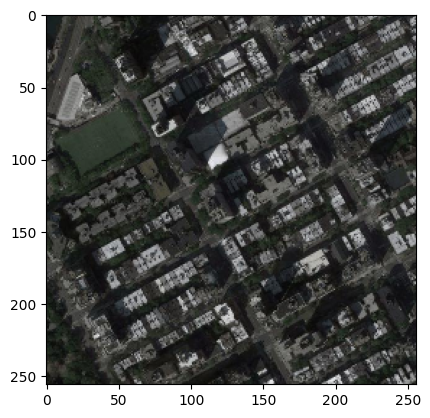

In [21]:
import matplotlib.pyplot as plt
import numpy as np

for X, y in trainloader:
    imageX = X[0]
    # imagey = y[0]

    imageX = imageX.permute(1, 2, 0).numpy()
    # imagey = imagey.permute(1, 2, 0).numpy()
    # Plot the image
    plt.imshow(imageX)
    # plt.imshow(imagey)
    plt.show()
    plt.show()
    break


In [22]:
#Training loop


import random
from tqdm import tqdm


unet.train()
discriminator.train()

iters = 0

writer_fake = SummaryWriter(f"logs/fake")
writer_real = SummaryWriter(f"logs/real")


for epoch in tqdm(range(epochs)):

    for X, y in trainloader:

    
        X = X.to(ModelArgs.device)
        y = y.to(ModelArgs.device)
        
        # print(X.shape)
        # print(y.shape)
        
        #Train the discriminator (with real data)

        ############################
        # (1) Update D network: maximize: log(1 - D(G(z)))
        ###########################
        
        #Enabling the discriminators trainable ability 
        for params in discriminator.parameters():
            params.requires_grad_ = True            
            
        current_batch_size = X.shape[0]  #Getting the current batch size
        
        real_data = torch.ones((current_batch_size,), device=ModelArgs.device, dtype=torch.float32)

        # 1. Forward pass
        y_pred = discriminator(X, y).mean(dim=[2,3]).squeeze(dim=1)
        # print(y_pred)
        # print(y_pred.shape)
        # 2. Calculate  and accumulate loss
        loss_real = loss_fn(y_pred, real_data)

        # 3. Optimizer zero grad
        optimizerD.zero_grad()

       
        # loss_real.backward()


        #Train the discriminator (with fake data)

        # noise = torch.randn((batch_size, latent_vector_size, 1, 1), device=device)
        fake_data = torch.zeros(( current_batch_size,), device=ModelArgs.device, dtype=torch.float32)
        mask_generated_by_generator = unet(X)

        #1. Forward pass
        y_pred = discriminator(X,mask_generated_by_generator.detach()).mean(dim=[2,3]).squeeze(dim=1)


        # 2. Calculate  and accumulate loss
        loss_fake = loss_fn(y_pred, fake_data)


        #Accumulating total discriminator loss
        discriminator_combined_loss = (loss_real + loss_fake) * 0.5
        loss_d.append(discriminator_combined_loss.item())

         # 4. Loss backward
        discriminator_combined_loss.backward()
        
         # 5. Optimizer step
        optimizerD.step()


        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        
        #Disabling the discriminators trainable ability 
        for params in discriminator.parameters():
            params.requires_grad_ = False
            
        # mask_generated_by_generator = unet(X)
        labels = torch.ones((current_batch_size,), device=ModelArgs.device, dtype=torch.float32)

        #1. Forward pass
        y_pred = discriminator(X, mask_generated_by_generator).mean(dim=[2,3]).squeeze(dim=1)
        # y_pred = torch.argmax(probs, dim=1).type(torch.float32)


        #2. Calculate and accumulate loss
        loss_gen = loss_fn(y_pred,labels) + ModelArgs.lambda_gen * (nn.functional.l1_loss(mask_generated_by_generator, y))


        # 3. Optimizer zero grad
        optimizerG.zero_grad()

        # 4. Loss backward
        loss_gen.backward()

        # 5. Optimizer step
        optimizerG.step()

        loss_g.append(loss_gen.item())


        if iters % 500 == 0:
            print("Iterations: ", iters, "Epoch: ", epoch, "Generator loss: ", loss_gen.item(), "Discriminator loss: ", discriminator_combined_loss.item())

        #save the output
        # with torch.inference_mode():
            
            
            
        if iters % 500 == 0:
            
            print('saving the output')
            torchvision.utils.save_image(y,'{}/real_images_iters_{}.png'.format(save_images, iters),normalize=True)
            fake = unet(X)
            torchvision.utils.save_image(fake,'{}/fake_images_iters_{}.png'.format(save_images, iters),normalize=True)

            img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
            img_grid_real = torchvision.utils.make_grid(y, normalize=True)
            # img_grid_map = torchvision.utils.make_grid(X, normalize=True)
                
            writer_fake.add_image(
                        "Map2erial Fake Images", img_grid_fake, global_step=iters
                    )
            writer_real.add_image(
                        "Map2Aerial Mask Images", img_grid_real, global_step=iters
                    )
            
            # writer_real.add_image(
            #             "Map2Aerial Aerial Images", img_grid_map, global_step=iters
            #         )
                    

            # Check pointing for every epoch
            # torch.save(generator.state_dict(), 'weights/CelebA/generator_steps_%d.pth' % (iters))
            # torch.save(discriminator.state_dict(), 'weights/CelebA/discriminator_steps_%d.pth' % (iters))


        iters += 1


  0%|          | 0/200 [00:00<?, ?it/s]

Iterations:  0 Epoch:  0 Generator loss:  83.75187683105469 Discriminator loss:  0.7039205431938171
saving the output
Iterations:  500 Epoch:  0 Generator loss:  10.83897876739502 Discriminator loss:  0.9554570317268372
saving the output
Iterations:  1000 Epoch:  0 Generator loss:  9.843153953552246 Discriminator loss:  0.5596585273742676
saving the output


  0%|          | 1/200 [01:47<5:56:08, 107.38s/it]

Iterations:  1500 Epoch:  1 Generator loss:  5.342258930206299 Discriminator loss:  0.7175567150115967
saving the output
Iterations:  2000 Epoch:  1 Generator loss:  4.7650933265686035 Discriminator loss:  0.7378393411636353
saving the output


  1%|          | 2/200 [03:50<6:25:43, 116.89s/it]

Iterations:  2500 Epoch:  2 Generator loss:  4.046691417694092 Discriminator loss:  0.5904740691184998
saving the output
Iterations:  3000 Epoch:  2 Generator loss:  6.641479969024658 Discriminator loss:  0.256919801235199
saving the output


  2%|▏         | 3/200 [05:57<6:37:44, 121.14s/it]

Iterations:  3500 Epoch:  3 Generator loss:  5.978009223937988 Discriminator loss:  0.320709764957428
saving the output
Iterations:  4000 Epoch:  3 Generator loss:  6.364668369293213 Discriminator loss:  0.16073954105377197
saving the output


  2%|▏         | 4/200 [08:01<6:39:57, 122.44s/it]

Iterations:  4500 Epoch:  4 Generator loss:  8.773744583129883 Discriminator loss:  0.2698599398136139
saving the output
Iterations:  5000 Epoch:  4 Generator loss:  8.656087875366211 Discriminator loss:  0.17114245891571045
saving the output


  2%|▎         | 5/200 [10:07<6:41:40, 123.59s/it]

Iterations:  5500 Epoch:  5 Generator loss:  5.592310428619385 Discriminator loss:  0.7625845670700073
saving the output
Iterations:  6000 Epoch:  5 Generator loss:  6.299828052520752 Discriminator loss:  0.6957265138626099
saving the output
Iterations:  6500 Epoch:  5 Generator loss:  5.610584259033203 Discriminator loss:  0.283901572227478
saving the output


  3%|▎         | 6/200 [12:09<6:38:25, 123.22s/it]

Iterations:  7000 Epoch:  6 Generator loss:  3.776212692260742 Discriminator loss:  0.3274754285812378
saving the output
Iterations:  7500 Epoch:  6 Generator loss:  4.606759548187256 Discriminator loss:  0.33326467871665955
saving the output


  4%|▎         | 7/200 [14:12<6:35:48, 123.05s/it]

Iterations:  8000 Epoch:  7 Generator loss:  6.621406078338623 Discriminator loss:  0.2215677946805954
saving the output
Iterations:  8500 Epoch:  7 Generator loss:  5.410435199737549 Discriminator loss:  0.23142105340957642
saving the output


  4%|▍         | 8/200 [16:13<6:32:13, 122.57s/it]

Iterations:  9000 Epoch:  8 Generator loss:  8.540616989135742 Discriminator loss:  0.2290811389684677
saving the output
Iterations:  9500 Epoch:  8 Generator loss:  7.238128185272217 Discriminator loss:  0.15590059757232666
saving the output


  4%|▍         | 9/200 [18:13<6:26:57, 121.56s/it]

Iterations:  10000 Epoch:  9 Generator loss:  7.646239280700684 Discriminator loss:  0.10787440836429596
saving the output
Iterations:  10500 Epoch:  9 Generator loss:  5.168174743652344 Discriminator loss:  0.10713286697864532
saving the output


  5%|▌         | 10/200 [20:12<6:22:44, 120.87s/it]

Iterations:  11000 Epoch:  10 Generator loss:  5.178112506866455 Discriminator loss:  0.5236691236495972
saving the output
Iterations:  11500 Epoch:  10 Generator loss:  5.313735008239746 Discriminator loss:  0.16280174255371094
saving the output
Iterations:  12000 Epoch:  10 Generator loss:  9.749462127685547 Discriminator loss:  0.3590596318244934
saving the output


  6%|▌         | 11/200 [22:08<6:15:47, 119.30s/it]

Iterations:  12500 Epoch:  11 Generator loss:  9.80942440032959 Discriminator loss:  0.1558782309293747
saving the output
Iterations:  13000 Epoch:  11 Generator loss:  4.280190944671631 Discriminator loss:  0.42022189497947693
saving the output


  6%|▌         | 12/200 [23:59<6:06:03, 116.83s/it]

Iterations:  13500 Epoch:  12 Generator loss:  7.323391914367676 Discriminator loss:  0.281328022480011
saving the output
Iterations:  14000 Epoch:  12 Generator loss:  5.962327003479004 Discriminator loss:  0.2115054726600647
saving the output


  6%|▋         | 13/200 [25:51<5:59:31, 115.36s/it]

Iterations:  14500 Epoch:  13 Generator loss:  6.852650165557861 Discriminator loss:  0.5475685000419617
saving the output
Iterations:  15000 Epoch:  13 Generator loss:  5.53062105178833 Discriminator loss:  0.05937762185931206
saving the output


  7%|▋         | 14/200 [27:41<5:52:36, 113.75s/it]

Iterations:  15500 Epoch:  14 Generator loss:  5.698197841644287 Discriminator loss:  0.14300064742565155
saving the output
Iterations:  16000 Epoch:  14 Generator loss:  2.827953815460205 Discriminator loss:  0.4022987484931946
saving the output


  8%|▊         | 15/200 [29:34<5:49:47, 113.44s/it]

Iterations:  16500 Epoch:  15 Generator loss:  5.7316765785217285 Discriminator loss:  0.21676018834114075
saving the output
Iterations:  17000 Epoch:  15 Generator loss:  6.447990417480469 Discriminator loss:  0.12926581501960754
saving the output
Iterations:  17500 Epoch:  15 Generator loss:  5.044898986816406 Discriminator loss:  0.1373240053653717
saving the output


  8%|▊         | 16/200 [31:24<5:45:09, 112.55s/it]

Iterations:  18000 Epoch:  16 Generator loss:  5.407029151916504 Discriminator loss:  0.27367904782295227
saving the output
Iterations:  18500 Epoch:  16 Generator loss:  4.685589790344238 Discriminator loss:  0.11859769374132156
saving the output


  8%|▊         | 17/200 [33:16<5:42:10, 112.19s/it]

Iterations:  19000 Epoch:  17 Generator loss:  6.049241065979004 Discriminator loss:  0.05691239610314369
saving the output
Iterations:  19500 Epoch:  17 Generator loss:  8.111766815185547 Discriminator loss:  0.10228505730628967
saving the output


  9%|▉         | 18/200 [35:07<5:39:19, 111.86s/it]

Iterations:  20000 Epoch:  18 Generator loss:  5.256300926208496 Discriminator loss:  0.0659218281507492
saving the output
Iterations:  20500 Epoch:  18 Generator loss:  8.36664867401123 Discriminator loss:  0.17717395722866058
saving the output


 10%|▉         | 19/200 [36:55<5:34:05, 110.75s/it]

Iterations:  21000 Epoch:  19 Generator loss:  7.848537445068359 Discriminator loss:  0.3546498715877533
saving the output
Iterations:  21500 Epoch:  19 Generator loss:  6.719961166381836 Discriminator loss:  0.27005502581596375
saving the output


 10%|█         | 20/200 [38:48<5:34:00, 111.34s/it]

Iterations:  22000 Epoch:  20 Generator loss:  6.806140899658203 Discriminator loss:  0.09911160916090012
saving the output
Iterations:  22500 Epoch:  20 Generator loss:  8.520115852355957 Discriminator loss:  0.0528159961104393
saving the output
Iterations:  23000 Epoch:  20 Generator loss:  9.067113876342773 Discriminator loss:  0.05556546896696091
saving the output


 10%|█         | 21/200 [40:40<5:32:58, 111.61s/it]

Iterations:  23500 Epoch:  21 Generator loss:  8.461891174316406 Discriminator loss:  0.05752094089984894
saving the output
Iterations:  24000 Epoch:  21 Generator loss:  6.568536281585693 Discriminator loss:  0.04734485223889351
saving the output


 11%|█         | 22/200 [42:29<5:28:41, 110.80s/it]

Iterations:  24500 Epoch:  22 Generator loss:  7.15248966217041 Discriminator loss:  0.04690929874777794
saving the output
Iterations:  25000 Epoch:  22 Generator loss:  9.012413024902344 Discriminator loss:  0.0681469663977623
saving the output


 12%|█▏        | 23/200 [44:20<5:27:00, 110.85s/it]

Iterations:  25500 Epoch:  23 Generator loss:  6.282900810241699 Discriminator loss:  0.18057847023010254
saving the output
Iterations:  26000 Epoch:  23 Generator loss:  6.524898529052734 Discriminator loss:  0.023056726902723312
saving the output


 12%|█▏        | 24/200 [46:08<5:23:09, 110.17s/it]

Iterations:  26500 Epoch:  24 Generator loss:  8.743719100952148 Discriminator loss:  0.12005443871021271
saving the output
Iterations:  27000 Epoch:  24 Generator loss:  8.365750312805176 Discriminator loss:  0.07307443767786026
saving the output


 12%|█▎        | 25/200 [47:59<5:21:52, 110.35s/it]

Iterations:  27500 Epoch:  25 Generator loss:  6.279455184936523 Discriminator loss:  0.2935660183429718
saving the output
Iterations:  28000 Epoch:  25 Generator loss:  7.797280788421631 Discriminator loss:  0.01183395553380251
saving the output


 13%|█▎        | 26/200 [49:52<5:22:12, 111.10s/it]

Iterations:  28500 Epoch:  26 Generator loss:  5.780092239379883 Discriminator loss:  0.5707388520240784
saving the output
Iterations:  29000 Epoch:  26 Generator loss:  6.9212846755981445 Discriminator loss:  0.029645835980772972
saving the output
Iterations:  29500 Epoch:  26 Generator loss:  3.603928565979004 Discriminator loss:  0.07150782644748688
saving the output


 14%|█▎        | 27/200 [51:42<5:19:32, 110.83s/it]

Iterations:  30000 Epoch:  27 Generator loss:  5.686677932739258 Discriminator loss:  0.043028026819229126
saving the output
Iterations:  30500 Epoch:  27 Generator loss:  9.09469985961914 Discriminator loss:  0.03226940333843231
saving the output


 14%|█▍        | 28/200 [53:35<5:19:07, 111.32s/it]

Iterations:  31000 Epoch:  28 Generator loss:  9.608678817749023 Discriminator loss:  0.032340534031391144
saving the output
Iterations:  31500 Epoch:  28 Generator loss:  6.806182861328125 Discriminator loss:  0.01714424416422844
saving the output


 14%|█▍        | 29/200 [55:25<5:16:26, 111.03s/it]

Iterations:  32000 Epoch:  29 Generator loss:  6.622133731842041 Discriminator loss:  0.04911479353904724
saving the output
Iterations:  32500 Epoch:  29 Generator loss:  6.8601861000061035 Discriminator loss:  0.05047444999217987
saving the output


 15%|█▌        | 30/200 [57:16<5:14:42, 111.07s/it]

Iterations:  33000 Epoch:  30 Generator loss:  6.933774948120117 Discriminator loss:  0.009700455702841282
saving the output
Iterations:  33500 Epoch:  30 Generator loss:  4.739424705505371 Discriminator loss:  0.11085118353366852
saving the output


 16%|█▌        | 31/200 [59:05<5:11:02, 110.43s/it]

Iterations:  34000 Epoch:  31 Generator loss:  6.324375152587891 Discriminator loss:  0.12150955945253372
saving the output
Iterations:  34500 Epoch:  31 Generator loss:  5.120615005493164 Discriminator loss:  0.05106298625469208
saving the output
Iterations:  35000 Epoch:  31 Generator loss:  7.396641731262207 Discriminator loss:  0.06874392181634903
saving the output


 16%|█▌        | 32/200 [1:00:59<5:12:02, 111.44s/it]

Iterations:  35500 Epoch:  32 Generator loss:  5.411343097686768 Discriminator loss:  0.052848972380161285
saving the output
Iterations:  36000 Epoch:  32 Generator loss:  9.192113876342773 Discriminator loss:  0.09377516061067581
saving the output


 16%|█▋        | 33/200 [1:02:51<5:10:27, 111.54s/it]

Iterations:  36500 Epoch:  33 Generator loss:  8.093558311462402 Discriminator loss:  0.061685577034950256
saving the output
Iterations:  37000 Epoch:  33 Generator loss:  5.625912666320801 Discriminator loss:  0.21353955566883087
saving the output


 17%|█▋        | 34/200 [1:04:41<5:07:49, 111.26s/it]

Iterations:  37500 Epoch:  34 Generator loss:  6.054295063018799 Discriminator loss:  0.047382425516843796
saving the output
Iterations:  38000 Epoch:  34 Generator loss:  8.078104019165039 Discriminator loss:  0.016556723043322563
saving the output


 18%|█▊        | 35/200 [1:06:33<5:06:07, 111.32s/it]

Iterations:  38500 Epoch:  35 Generator loss:  4.269482135772705 Discriminator loss:  0.08247905969619751
saving the output
Iterations:  39000 Epoch:  35 Generator loss:  7.26639461517334 Discriminator loss:  0.133999302983284
saving the output


 18%|█▊        | 36/200 [1:08:24<5:04:00, 111.22s/it]

Iterations:  39500 Epoch:  36 Generator loss:  7.2749433517456055 Discriminator loss:  0.044954441487789154
saving the output
Iterations:  40000 Epoch:  36 Generator loss:  5.951778888702393 Discriminator loss:  0.4048209488391876
saving the output
Iterations:  40500 Epoch:  36 Generator loss:  6.077204704284668 Discriminator loss:  0.07169743627309799
saving the output


 18%|█▊        | 37/200 [1:10:16<5:02:48, 111.46s/it]

Iterations:  41000 Epoch:  37 Generator loss:  6.799302101135254 Discriminator loss:  0.012126468122005463
saving the output
Iterations:  41500 Epoch:  37 Generator loss:  6.170685768127441 Discriminator loss:  0.06198114529252052
saving the output


 19%|█▉        | 38/200 [1:12:05<4:58:57, 110.72s/it]

Iterations:  42000 Epoch:  38 Generator loss:  6.215989589691162 Discriminator loss:  0.05905861407518387
saving the output
Iterations:  42500 Epoch:  38 Generator loss:  7.914500713348389 Discriminator loss:  0.021916409954428673
saving the output


 20%|█▉        | 39/200 [1:13:57<4:58:48, 111.36s/it]

Iterations:  43000 Epoch:  39 Generator loss:  6.619028091430664 Discriminator loss:  0.2546430230140686
saving the output
Iterations:  43500 Epoch:  39 Generator loss:  7.233001708984375 Discriminator loss:  0.034534528851509094
saving the output


 20%|██        | 40/200 [1:15:48<4:55:56, 110.98s/it]

Iterations:  44000 Epoch:  40 Generator loss:  8.07421875 Discriminator loss:  0.03690766170620918
saving the output
Iterations:  44500 Epoch:  40 Generator loss:  7.7892866134643555 Discriminator loss:  0.060614801943302155
saving the output


 20%|██        | 41/200 [1:17:40<4:55:10, 111.38s/it]

Iterations:  45000 Epoch:  41 Generator loss:  8.589282989501953 Discriminator loss:  0.08691684156656265
saving the output
Iterations:  45500 Epoch:  41 Generator loss:  10.99944019317627 Discriminator loss:  0.02728245221078396
saving the output
Iterations:  46000 Epoch:  41 Generator loss:  8.551020622253418 Discriminator loss:  0.06277833878993988
saving the output


 21%|██        | 42/200 [1:19:29<4:51:45, 110.80s/it]

Iterations:  46500 Epoch:  42 Generator loss:  5.409415245056152 Discriminator loss:  0.034538716077804565
saving the output
Iterations:  47000 Epoch:  42 Generator loss:  6.580872058868408 Discriminator loss:  0.020680921152234077
saving the output


 22%|██▏       | 43/200 [1:21:20<4:49:56, 110.80s/it]

Iterations:  47500 Epoch:  43 Generator loss:  4.907678127288818 Discriminator loss:  0.06254750490188599
saving the output
Iterations:  48000 Epoch:  43 Generator loss:  7.217616081237793 Discriminator loss:  0.02329476922750473
saving the output


 22%|██▏       | 44/200 [1:23:13<4:49:38, 111.40s/it]

Iterations:  48500 Epoch:  44 Generator loss:  7.2928786277771 Discriminator loss:  0.03664514794945717
saving the output
Iterations:  49000 Epoch:  44 Generator loss:  7.98463773727417 Discriminator loss:  0.02669677697122097
saving the output


 22%|██▎       | 45/200 [1:25:03<4:47:04, 111.13s/it]

Iterations:  49500 Epoch:  45 Generator loss:  6.671917915344238 Discriminator loss:  0.036848150193691254
saving the output
Iterations:  50000 Epoch:  45 Generator loss:  7.789425849914551 Discriminator loss:  0.08228743076324463
saving the output


 23%|██▎       | 46/200 [1:26:56<4:46:07, 111.48s/it]

Iterations:  50500 Epoch:  46 Generator loss:  6.796608924865723 Discriminator loss:  0.19659216701984406
saving the output
Iterations:  51000 Epoch:  46 Generator loss:  6.781185626983643 Discriminator loss:  0.058826643973588943
saving the output
Iterations:  51500 Epoch:  46 Generator loss:  9.42552375793457 Discriminator loss:  0.03342457115650177
saving the output


 24%|██▎       | 47/200 [1:28:46<4:43:40, 111.25s/it]

Iterations:  52000 Epoch:  47 Generator loss:  7.026267051696777 Discriminator loss:  0.03425368294119835
saving the output
Iterations:  52500 Epoch:  47 Generator loss:  6.562072277069092 Discriminator loss:  0.2652299702167511
saving the output


 24%|██▍       | 48/200 [1:30:38<4:41:59, 111.31s/it]

Iterations:  53000 Epoch:  48 Generator loss:  3.6221508979797363 Discriminator loss:  0.2662387192249298
saving the output
Iterations:  53500 Epoch:  48 Generator loss:  7.580875873565674 Discriminator loss:  0.01848570443689823
saving the output


 24%|██▍       | 49/200 [1:32:27<4:38:10, 110.53s/it]

Iterations:  54000 Epoch:  49 Generator loss:  9.519166946411133 Discriminator loss:  0.02484005317091942
saving the output
Iterations:  54500 Epoch:  49 Generator loss:  5.690535068511963 Discriminator loss:  0.09764964878559113
saving the output


 25%|██▌       | 50/200 [1:34:19<4:37:41, 111.08s/it]

Iterations:  55000 Epoch:  50 Generator loss:  7.322561264038086 Discriminator loss:  0.02289423905313015
saving the output
Iterations:  55500 Epoch:  50 Generator loss:  4.979272842407227 Discriminator loss:  0.023021509870886803
saving the output


 26%|██▌       | 51/200 [1:36:09<4:34:56, 110.71s/it]

Iterations:  56000 Epoch:  51 Generator loss:  9.399587631225586 Discriminator loss:  0.026049330830574036
saving the output
Iterations:  56500 Epoch:  51 Generator loss:  6.370345115661621 Discriminator loss:  0.02086295560002327
saving the output


 26%|██▌       | 52/200 [1:38:00<4:33:44, 110.98s/it]

Iterations:  57000 Epoch:  52 Generator loss:  8.71065902709961 Discriminator loss:  0.01684824749827385
saving the output
Iterations:  57500 Epoch:  52 Generator loss:  8.344430923461914 Discriminator loss:  0.01049867458641529
saving the output
Iterations:  58000 Epoch:  52 Generator loss:  5.198055267333984 Discriminator loss:  0.03947984427213669
saving the output


 26%|██▋       | 53/200 [1:39:50<4:31:08, 110.67s/it]

Iterations:  58500 Epoch:  53 Generator loss:  6.7921037673950195 Discriminator loss:  0.01618885062634945
saving the output
Iterations:  59000 Epoch:  53 Generator loss:  6.894698143005371 Discriminator loss:  0.1685618907213211
saving the output


 27%|██▋       | 54/200 [1:41:40<4:28:39, 110.41s/it]

Iterations:  59500 Epoch:  54 Generator loss:  7.6744184494018555 Discriminator loss:  0.11014197766780853
saving the output
Iterations:  60000 Epoch:  54 Generator loss:  6.141111373901367 Discriminator loss:  0.05177281051874161
saving the output


 28%|██▊       | 55/200 [1:43:30<4:26:31, 110.28s/it]

Iterations:  60500 Epoch:  55 Generator loss:  10.402681350708008 Discriminator loss:  0.009586871601641178
saving the output
Iterations:  61000 Epoch:  55 Generator loss:  9.424013137817383 Discriminator loss:  0.027971412986516953
saving the output


 28%|██▊       | 56/200 [1:45:20<4:24:09, 110.07s/it]

Iterations:  61500 Epoch:  56 Generator loss:  6.226119041442871 Discriminator loss:  0.12714621424674988
saving the output
Iterations:  62000 Epoch:  56 Generator loss:  7.958732604980469 Discriminator loss:  0.024021172896027565
saving the output


 28%|██▊       | 57/200 [1:47:10<4:22:41, 110.22s/it]

Iterations:  62500 Epoch:  57 Generator loss:  7.881805419921875 Discriminator loss:  0.060130465775728226
saving the output
Iterations:  63000 Epoch:  57 Generator loss:  7.585508346557617 Discriminator loss:  0.05257517844438553
saving the output
Iterations:  63500 Epoch:  57 Generator loss:  8.068987846374512 Discriminator loss:  0.050765737891197205
saving the output


 29%|██▉       | 58/200 [1:49:02<4:21:59, 110.70s/it]

Iterations:  64000 Epoch:  58 Generator loss:  10.072380065917969 Discriminator loss:  0.09014613926410675
saving the output
Iterations:  64500 Epoch:  58 Generator loss:  6.671736717224121 Discriminator loss:  0.0562870055437088
saving the output


 30%|██▉       | 59/200 [1:50:54<4:20:53, 111.02s/it]

Iterations:  65000 Epoch:  59 Generator loss:  6.055968761444092 Discriminator loss:  0.12596732378005981
saving the output
Iterations:  65500 Epoch:  59 Generator loss:  7.957114219665527 Discriminator loss:  0.03151588514447212
saving the output


 30%|███       | 60/200 [1:52:38<4:14:21, 109.01s/it]

Iterations:  66000 Epoch:  60 Generator loss:  9.913172721862793 Discriminator loss:  0.07933885604143143
saving the output
Iterations:  66500 Epoch:  60 Generator loss:  7.988312721252441 Discriminator loss:  0.02025214582681656
saving the output


 30%|███       | 61/200 [1:54:25<4:10:44, 108.23s/it]

Iterations:  67000 Epoch:  61 Generator loss:  9.673952102661133 Discriminator loss:  0.01668166182935238
saving the output
Iterations:  67500 Epoch:  61 Generator loss:  9.08202075958252 Discriminator loss:  0.012791089713573456
saving the output


 31%|███       | 62/200 [1:56:12<4:08:37, 108.10s/it]

Iterations:  68000 Epoch:  62 Generator loss:  9.880929946899414 Discriminator loss:  0.044258780777454376
saving the output
Iterations:  68500 Epoch:  62 Generator loss:  8.82491397857666 Discriminator loss:  0.012100298888981342
saving the output
Iterations:  69000 Epoch:  62 Generator loss:  6.461591720581055 Discriminator loss:  0.01651102304458618
saving the output


 32%|███▏      | 63/200 [1:58:05<4:09:44, 109.38s/it]

Iterations:  69500 Epoch:  63 Generator loss:  7.768218040466309 Discriminator loss:  0.23123522102832794
saving the output
Iterations:  70000 Epoch:  63 Generator loss:  11.397248268127441 Discriminator loss:  0.04202668368816376
saving the output


 32%|███▏      | 64/200 [1:59:54<4:08:01, 109.42s/it]

Iterations:  70500 Epoch:  64 Generator loss:  10.268515586853027 Discriminator loss:  0.01243589073419571
saving the output
Iterations:  71000 Epoch:  64 Generator loss:  5.759803295135498 Discriminator loss:  0.01878645084798336
saving the output


 32%|███▎      | 65/200 [2:01:44<4:06:26, 109.53s/it]

Iterations:  71500 Epoch:  65 Generator loss:  6.546440601348877 Discriminator loss:  0.09653377532958984
saving the output
Iterations:  72000 Epoch:  65 Generator loss:  5.191305160522461 Discriminator loss:  0.04059785231947899
saving the output


 33%|███▎      | 66/200 [2:03:33<4:04:24, 109.44s/it]

Iterations:  72500 Epoch:  66 Generator loss:  5.601597309112549 Discriminator loss:  0.16576838493347168
saving the output
Iterations:  73000 Epoch:  66 Generator loss:  7.077064514160156 Discriminator loss:  0.010151066817343235
saving the output


 34%|███▎      | 67/200 [2:05:19<4:00:00, 108.27s/it]

Iterations:  73500 Epoch:  67 Generator loss:  7.931463718414307 Discriminator loss:  0.020045431330800056
saving the output
Iterations:  74000 Epoch:  67 Generator loss:  8.339520454406738 Discriminator loss:  0.024458907544612885
saving the output
Iterations:  74500 Epoch:  67 Generator loss:  8.161299705505371 Discriminator loss:  0.03672843798995018
saving the output


 34%|███▍      | 68/200 [2:07:10<3:59:53, 109.04s/it]

Iterations:  75000 Epoch:  68 Generator loss:  9.4618501663208 Discriminator loss:  0.08043624460697174
saving the output
Iterations:  75500 Epoch:  68 Generator loss:  13.373943328857422 Discriminator loss:  0.010326401330530643
saving the output


 34%|███▍      | 69/200 [2:09:00<3:59:10, 109.54s/it]

Iterations:  76000 Epoch:  69 Generator loss:  8.656570434570312 Discriminator loss:  0.05398356541991234
saving the output
Iterations:  76500 Epoch:  69 Generator loss:  12.176553726196289 Discriminator loss:  0.02004975825548172
saving the output


 35%|███▌      | 70/200 [2:10:49<3:56:56, 109.35s/it]

Iterations:  77000 Epoch:  70 Generator loss:  9.478293418884277 Discriminator loss:  0.046417463570833206
saving the output
Iterations:  77500 Epoch:  70 Generator loss:  8.557939529418945 Discriminator loss:  0.094144806265831
saving the output


 36%|███▌      | 71/200 [2:12:39<3:55:33, 109.56s/it]

Iterations:  78000 Epoch:  71 Generator loss:  7.892962455749512 Discriminator loss:  0.31735700368881226
saving the output
Iterations:  78500 Epoch:  71 Generator loss:  10.142900466918945 Discriminator loss:  0.00634266110137105
saving the output


 36%|███▌      | 72/200 [2:14:26<3:52:01, 108.76s/it]

Iterations:  79000 Epoch:  72 Generator loss:  7.425325870513916 Discriminator loss:  0.09619647264480591
saving the output
Iterations:  79500 Epoch:  72 Generator loss:  10.294519424438477 Discriminator loss:  0.01748303882777691
saving the output
Iterations:  80000 Epoch:  72 Generator loss:  8.370429992675781 Discriminator loss:  0.0442974679172039
saving the output


 36%|███▋      | 73/200 [2:16:14<3:49:41, 108.51s/it]

Iterations:  80500 Epoch:  73 Generator loss:  8.812653541564941 Discriminator loss:  0.009866944514214993
saving the output
Iterations:  81000 Epoch:  73 Generator loss:  5.233015060424805 Discriminator loss:  0.30346202850341797
saving the output


 37%|███▋      | 74/200 [2:18:04<3:48:57, 109.03s/it]

Iterations:  81500 Epoch:  74 Generator loss:  9.20102310180664 Discriminator loss:  0.017190536484122276
saving the output
Iterations:  82000 Epoch:  74 Generator loss:  20.139739990234375 Discriminator loss:  0.004356938414275646
saving the output


 38%|███▊      | 75/200 [2:19:51<3:45:50, 108.41s/it]

Iterations:  82500 Epoch:  75 Generator loss:  16.896896362304688 Discriminator loss:  3.596240503611625e-06
saving the output
Iterations:  83000 Epoch:  75 Generator loss:  14.153632164001465 Discriminator loss:  0.003304415149614215
saving the output


 38%|███▊      | 76/200 [2:21:40<3:44:22, 108.57s/it]

Iterations:  83500 Epoch:  76 Generator loss:  9.85753345489502 Discriminator loss:  0.02852349355816841
saving the output
Iterations:  84000 Epoch:  76 Generator loss:  8.398286819458008 Discriminator loss:  0.20067621767520905
saving the output


 38%|███▊      | 77/200 [2:23:28<3:41:43, 108.16s/it]

Iterations:  84500 Epoch:  77 Generator loss:  15.16966438293457 Discriminator loss:  0.0008336750324815512
saving the output
Iterations:  85000 Epoch:  77 Generator loss:  15.770729064941406 Discriminator loss:  3.9064965676516294e-05
saving the output


 39%|███▉      | 78/200 [2:25:16<3:39:51, 108.12s/it]

Iterations:  85500 Epoch:  78 Generator loss:  22.767807006835938 Discriminator loss:  5.2264899750298355e-06
saving the output
Iterations:  86000 Epoch:  78 Generator loss:  10.786834716796875 Discriminator loss:  0.004481888841837645
saving the output
Iterations:  86500 Epoch:  78 Generator loss:  11.570856094360352 Discriminator loss:  0.0006545624928548932
saving the output


 40%|███▉      | 79/200 [2:27:03<3:37:45, 107.98s/it]

Iterations:  87000 Epoch:  79 Generator loss:  18.257164001464844 Discriminator loss:  0.0003158685576636344
saving the output
Iterations:  87500 Epoch:  79 Generator loss:  9.657706260681152 Discriminator loss:  0.01990078203380108
saving the output


 40%|████      | 80/200 [2:28:50<3:35:10, 107.59s/it]

Iterations:  88000 Epoch:  80 Generator loss:  11.963088989257812 Discriminator loss:  0.020610326901078224
saving the output
Iterations:  88500 Epoch:  80 Generator loss:  10.175487518310547 Discriminator loss:  0.02297690510749817
saving the output


 40%|████      | 81/200 [2:30:38<3:33:32, 107.67s/it]

Iterations:  89000 Epoch:  81 Generator loss:  8.209280967712402 Discriminator loss:  0.024482056498527527
saving the output
Iterations:  89500 Epoch:  81 Generator loss:  12.14295768737793 Discriminator loss:  0.004225478041917086
saving the output


 41%|████      | 82/200 [2:32:25<3:31:30, 107.55s/it]

Iterations:  90000 Epoch:  82 Generator loss:  12.71084976196289 Discriminator loss:  0.0011922928970307112
saving the output
Iterations:  90500 Epoch:  82 Generator loss:  21.850139617919922 Discriminator loss:  0.000611213908996433
saving the output


 42%|████▏     | 83/200 [2:34:15<3:31:04, 108.24s/it]

Iterations:  91000 Epoch:  83 Generator loss:  17.731552124023438 Discriminator loss:  0.007733000908046961
saving the output
Iterations:  91500 Epoch:  83 Generator loss:  15.906885147094727 Discriminator loss:  0.0002045689179794863
saving the output
Iterations:  92000 Epoch:  83 Generator loss:  22.051727294921875 Discriminator loss:  3.815759555436671e-05
saving the output


 42%|████▏     | 84/200 [2:36:03<3:29:28, 108.35s/it]

Iterations:  92500 Epoch:  84 Generator loss:  20.7127685546875 Discriminator loss:  0.0028670800384134054
saving the output
Iterations:  93000 Epoch:  84 Generator loss:  14.750038146972656 Discriminator loss:  0.0026874756440520287
saving the output


 42%|████▎     | 85/200 [2:37:54<3:28:43, 108.90s/it]

Iterations:  93500 Epoch:  85 Generator loss:  15.180255889892578 Discriminator loss:  0.00042850521276704967
saving the output
Iterations:  94000 Epoch:  85 Generator loss:  15.835844039916992 Discriminator loss:  0.0004313297104090452
saving the output


 43%|████▎     | 86/200 [2:39:41<3:26:06, 108.48s/it]

Iterations:  94500 Epoch:  86 Generator loss:  19.102230072021484 Discriminator loss:  0.0009159233304671943
saving the output
Iterations:  95000 Epoch:  86 Generator loss:  16.929452896118164 Discriminator loss:  5.559694272960769e-06
saving the output


 44%|████▎     | 87/200 [2:41:33<3:26:06, 109.44s/it]

Iterations:  95500 Epoch:  87 Generator loss:  20.43312644958496 Discriminator loss:  0.001993238925933838
saving the output
Iterations:  96000 Epoch:  87 Generator loss:  17.24042510986328 Discriminator loss:  6.963106716284528e-05
saving the output


 44%|████▍     | 88/200 [2:43:21<3:23:38, 109.09s/it]

Iterations:  96500 Epoch:  88 Generator loss:  20.075422286987305 Discriminator loss:  0.0007758861756883562
saving the output
Iterations:  97000 Epoch:  88 Generator loss:  11.157782554626465 Discriminator loss:  0.1280011683702469
saving the output
Iterations:  97500 Epoch:  88 Generator loss:  14.078516006469727 Discriminator loss:  0.011400025337934494
saving the output


 44%|████▍     | 89/200 [2:45:11<3:22:06, 109.25s/it]

Iterations:  98000 Epoch:  89 Generator loss:  18.891765594482422 Discriminator loss:  0.02053224667906761
saving the output
Iterations:  98500 Epoch:  89 Generator loss:  15.754075050354004 Discriminator loss:  0.0006438701529987156
saving the output


 45%|████▌     | 90/200 [2:47:01<3:20:38, 109.44s/it]

Iterations:  99000 Epoch:  90 Generator loss:  14.748644828796387 Discriminator loss:  0.006871298886835575
saving the output
Iterations:  99500 Epoch:  90 Generator loss:  11.97589111328125 Discriminator loss:  0.007254767697304487
saving the output


 46%|████▌     | 91/200 [2:48:48<3:17:51, 108.91s/it]

Iterations:  100000 Epoch:  91 Generator loss:  19.377567291259766 Discriminator loss:  1.5602699932060204e-05
saving the output
Iterations:  100500 Epoch:  91 Generator loss:  12.961721420288086 Discriminator loss:  0.00029152119532227516
saving the output


 46%|████▌     | 92/200 [2:50:36<3:15:17, 108.49s/it]

Iterations:  101000 Epoch:  92 Generator loss:  13.52735710144043 Discriminator loss:  3.1663970730733126e-05
saving the output
Iterations:  101500 Epoch:  92 Generator loss:  19.863941192626953 Discriminator loss:  0.008069303818047047
saving the output


 46%|████▋     | 93/200 [2:52:23<3:12:54, 108.17s/it]

Iterations:  102000 Epoch:  93 Generator loss:  10.974818229675293 Discriminator loss:  0.03003976121544838
saving the output
Iterations:  102500 Epoch:  93 Generator loss:  16.37773323059082 Discriminator loss:  1.0423878848087043e-05
saving the output
Iterations:  103000 Epoch:  93 Generator loss:  11.663265228271484 Discriminator loss:  0.009026538580656052
saving the output


 47%|████▋     | 94/200 [2:54:11<3:10:48, 108.01s/it]

Iterations:  103500 Epoch:  94 Generator loss:  14.376457214355469 Discriminator loss:  8.21502399048768e-05
saving the output
Iterations:  104000 Epoch:  94 Generator loss:  15.499567031860352 Discriminator loss:  8.374427125090733e-05
saving the output


 48%|████▊     | 95/200 [2:56:00<3:09:43, 108.42s/it]

Iterations:  104500 Epoch:  95 Generator loss:  15.624828338623047 Discriminator loss:  0.018251296132802963
saving the output
Iterations:  105000 Epoch:  95 Generator loss:  15.83316707611084 Discriminator loss:  9.494600089965388e-05
saving the output


 48%|████▊     | 96/200 [2:57:50<3:08:39, 108.85s/it]

Iterations:  105500 Epoch:  96 Generator loss:  12.883126258850098 Discriminator loss:  0.0027954799588769674
saving the output
Iterations:  106000 Epoch:  96 Generator loss:  16.05842399597168 Discriminator loss:  0.12719595432281494
saving the output


 48%|████▊     | 97/200 [2:59:45<3:09:47, 110.56s/it]

Iterations:  106500 Epoch:  97 Generator loss:  15.851101875305176 Discriminator loss:  0.045159291476011276
saving the output
Iterations:  107000 Epoch:  97 Generator loss:  18.052366256713867 Discriminator loss:  8.755329326959327e-05
saving the output


 49%|████▉     | 98/200 [3:01:41<3:10:49, 112.25s/it]

Iterations:  107500 Epoch:  98 Generator loss:  11.71098518371582 Discriminator loss:  0.0015069559449329972
saving the output
Iterations:  108000 Epoch:  98 Generator loss:  11.234979629516602 Discriminator loss:  0.003168534254655242
saving the output
Iterations:  108500 Epoch:  98 Generator loss:  10.038833618164062 Discriminator loss:  0.011534217745065689
saving the output


 50%|████▉     | 99/200 [3:03:31<3:07:39, 111.48s/it]

Iterations:  109000 Epoch:  99 Generator loss:  10.641927719116211 Discriminator loss:  0.0021384451538324356
saving the output
Iterations:  109500 Epoch:  99 Generator loss:  17.944927215576172 Discriminator loss:  0.025479810312390327
saving the output


 50%|█████     | 100/200 [3:05:22<3:05:59, 111.60s/it]

Iterations:  110000 Epoch:  100 Generator loss:  11.042086601257324 Discriminator loss:  0.008797110058367252
saving the output
Iterations:  110500 Epoch:  100 Generator loss:  12.412042617797852 Discriminator loss:  0.001102158334106207
saving the output


 50%|█████     | 101/200 [3:07:08<3:01:10, 109.80s/it]

Iterations:  111000 Epoch:  101 Generator loss:  9.161961555480957 Discriminator loss:  0.014838405884802341
saving the output
Iterations:  111500 Epoch:  101 Generator loss:  18.625762939453125 Discriminator loss:  0.00031669018790125847
saving the output


 51%|█████     | 102/200 [3:08:59<2:59:44, 110.04s/it]

Iterations:  112000 Epoch:  102 Generator loss:  9.139901161193848 Discriminator loss:  0.03316434100270271
saving the output
Iterations:  112500 Epoch:  102 Generator loss:  6.550443649291992 Discriminator loss:  0.6138962507247925
saving the output


 52%|█████▏    | 103/200 [3:10:50<2:58:47, 110.60s/it]

Iterations:  113000 Epoch:  103 Generator loss:  10.928133010864258 Discriminator loss:  0.0031668965239077806
saving the output
Iterations:  113500 Epoch:  103 Generator loss:  10.15194034576416 Discriminator loss:  0.0036551032681018114
saving the output


 52%|█████▏    | 104/200 [3:12:42<2:57:13, 110.77s/it]

Iterations:  114000 Epoch:  104 Generator loss:  8.667779922485352 Discriminator loss:  0.03353262320160866
saving the output
Iterations:  114500 Epoch:  104 Generator loss:  14.200674057006836 Discriminator loss:  0.005493605509400368
saving the output
Iterations:  115000 Epoch:  104 Generator loss:  11.012813568115234 Discriminator loss:  0.007443707436323166
saving the output


 52%|█████▎    | 105/200 [3:14:34<2:56:08, 111.25s/it]

Iterations:  115500 Epoch:  105 Generator loss:  12.630532264709473 Discriminator loss:  0.0035359039902687073
saving the output
Iterations:  116000 Epoch:  105 Generator loss:  18.536865234375 Discriminator loss:  0.0002123695012414828
saving the output


 53%|█████▎    | 106/200 [3:16:25<2:54:20, 111.28s/it]

Iterations:  116500 Epoch:  106 Generator loss:  11.112871170043945 Discriminator loss:  0.014127026312053204
saving the output
Iterations:  117000 Epoch:  106 Generator loss:  18.806718826293945 Discriminator loss:  0.025574825704097748
saving the output


 54%|█████▎    | 107/200 [3:18:18<2:52:54, 111.55s/it]

Iterations:  117500 Epoch:  107 Generator loss:  14.01613998413086 Discriminator loss:  0.03822965919971466
saving the output
Iterations:  118000 Epoch:  107 Generator loss:  11.529525756835938 Discriminator loss:  0.006321657914668322
saving the output


 54%|█████▍    | 108/200 [3:20:11<2:52:01, 112.19s/it]

Iterations:  118500 Epoch:  108 Generator loss:  10.89507007598877 Discriminator loss:  0.0013411841355264187
saving the output
Iterations:  119000 Epoch:  108 Generator loss:  11.793157577514648 Discriminator loss:  0.0011383940000087023
saving the output


 55%|█████▍    | 109/200 [3:22:04<2:50:19, 112.30s/it]

Iterations:  119500 Epoch:  109 Generator loss:  10.084601402282715 Discriminator loss:  0.010027577169239521
saving the output
Iterations:  120000 Epoch:  109 Generator loss:  18.147781372070312 Discriminator loss:  0.0006955359713174403
saving the output
Iterations:  120500 Epoch:  109 Generator loss:  8.558401107788086 Discriminator loss:  0.08167997002601624
saving the output


 55%|█████▌    | 110/200 [3:23:54<2:47:39, 111.77s/it]

Iterations:  121000 Epoch:  110 Generator loss:  8.921289443969727 Discriminator loss:  0.15873195230960846
saving the output
Iterations:  121500 Epoch:  110 Generator loss:  20.862682342529297 Discriminator loss:  9.614321925255354e-07
saving the output


 56%|█████▌    | 111/200 [3:25:51<2:48:05, 113.32s/it]

Iterations:  122000 Epoch:  111 Generator loss:  21.037437438964844 Discriminator loss:  2.473819040460512e-05
saving the output
Iterations:  122500 Epoch:  111 Generator loss:  10.431640625 Discriminator loss:  0.010106279514729977
saving the output


 56%|█████▌    | 112/200 [3:27:45<2:46:10, 113.30s/it]

Iterations:  123000 Epoch:  112 Generator loss:  26.00503158569336 Discriminator loss:  1.1008551155100577e-06
saving the output
Iterations:  123500 Epoch:  112 Generator loss:  10.51343822479248 Discriminator loss:  0.0028496268205344677
saving the output


 56%|█████▋    | 113/200 [3:29:38<2:44:33, 113.49s/it]

Iterations:  124000 Epoch:  113 Generator loss:  12.38020133972168 Discriminator loss:  0.003925044555217028
saving the output
Iterations:  124500 Epoch:  113 Generator loss:  17.98140525817871 Discriminator loss:  8.817180059850216e-05
saving the output


 57%|█████▋    | 114/200 [3:31:33<2:43:17, 113.92s/it]

Iterations:  125000 Epoch:  114 Generator loss:  13.55582046508789 Discriminator loss:  0.06346787512302399
saving the output
Iterations:  125500 Epoch:  114 Generator loss:  13.26333236694336 Discriminator loss:  0.0073095811530947685
saving the output
Iterations:  126000 Epoch:  114 Generator loss:  6.17825984954834 Discriminator loss:  0.35388630628585815
saving the output


 57%|█████▊    | 115/200 [3:34:07<2:38:15, 111.71s/it]


KeyboardInterrupt: 

In [ ]:
#For MNIST
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(loss_g,label="G")
plt.plot(loss_d,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

